## Import standard libraries

In [2]:
# Libraries used for hinting
from __future__ import annotations
from typing import Type, Union

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import file system libraries
from pathlib import Path
import os

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'scalib'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

Parent working directory: /Users/jjrr/Documents/SCA-Project/scalib


In [3]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Import custom libraries from local folder.
import sys
sys.path.append("..")

# Import utils library containing multiple functions/classes
from scalib import utils
from scalib import cfg

# Import class to create/manage CDMs
from scalib.cdm import ConjunctionDataMessage as CDM

# Import classes to handle Conjunction Events
from scalib.event import ConjunctionEvent as CE
from scalib.event import ConjunctionEventsDataset as CED

# Import NN classes to create NN models
from scalib.rnn import ConjunctionEventForecaster as CEF
from scalib.ann import CollisionRisk as CRE

from scalib.eda import kelvins_challenge_events

import pandas as pd
import numpy as np 

np.random.seed(1)

## Data preparation

In [4]:
class DatasetEventDataset(Dataset):
    def __init__(self, event_set:list, features:list, 
                 features_stats:dict = None) -> None:
                 
        # Initialize the list of events.
        self._event_set = event_set
        
        # Get the maximum number of CDMs stored in a single conjunction event. 
        # This internal variable will be used to pad the torch of every event 
        # with zeros, that is, empty CDM objects will be added to Events with 
        # less CDMs that max_event_length.
        self._max_event_length = max(map(len, self._event_set))
        self._features = features
        self._features_length = len(features)
        
        # Compute statistics for every feature if not already passed
        # into the class
        if features_stats is None:
            # Cast list of events objects to pandas DataFrame.
            df = event_set.to_dataframe()
            
            # Get list of features containing any missing value.
            null_features = df.columns[df.isnull().any()]
            for feature in features:
                if feature in null_features:
                    raise RuntimeError('Feature {} is not present in the ' + \
                                       'dataset'.format(feature))
                    
            # Convert feature data to numpy array to compute statistics.
            features_numpy = df[features].to_numpy() 
            self._features_stats = {'mean': features_numpy.mean(0), 
                                    'stddev': features_numpy.std(0)}
        else:
            self._features_stats = features_stats

    def __len__(self) -> int:
        return len(self._event_set)

    # 
    def __getitem__(self, i:int) -> tuple:
        """Get item from Events Dataset. 

        Args:
            i (int): Index of item to retrieve (CDM index).

        Returns:
            tuple: Tuple containing two tensors:
             - First item contains the feature values normalized. Dimensions 
                vary depending on the method used to retrieve the data:
                  + Single item (from Dataset): (max_event_length, features)
                  + Batch of items (DataLoader): (batch_size, max_event_length, 
                  features)
             - Second item stores the number of the CDM objects the event 
                contains. This item is required for packing padded torch and 
                optimize computing. Dimensions  vary depending on the method 
                used to retrieve the data:
                  + Single item (from Dataset): (max_event_length, 1)
                  + Batch of items (DataLoader): (batch_size, max_event_length, 1)
        """
        
        # Get event object from the set.
        event = self._event_set[i]
        
        # Initialize torch with zeros and shape (max_event_length, n_features).
        # This torch forces all events to have the same number of CDMs by using
        # the internal variable _max_event_length. It basically creates a padded
        # torch, which helps to do batch processing with the DataLoader class.
        x = torch.zeros(self._max_event_length, self._features_length)
        
        # Iterate over all CDM objects in the event i and apply standard 
        # normalization (x - mean)/(std + epsilon). Note: A constant epsilon
        # is introduced to remove value errors caused by division by zero.
        epsilon = 1e-8
        for i, cdm in enumerate(event):
            for j, feature in enumerate(self._features):
                # Get mean and standard deviation per feature.
                feature_mean = self._features_stats['mean'][j]
                feature_stddev = self._features_stats['stddev'][j]
                
                # Add normalzied feature to the tensor.
                x[i] = torch.tensor([(cdm[feature]-feature_mean)/\
                                     (feature_stddev+epsilon)])

        return x, torch.tensor(len(event))

In [5]:
class LayerConstructor(nn.Module):
    def __init__(self, layer_type:str, input_size:int, output_size:int,
        dropout:float = None, activation_function = None, **kwargs) -> None:
        super().__init__()

        # Check layer_type is either linear or lstm.
        if not layer_type in ['lstm', 'linear']:
            raise ValueError('Layer {} not recognised'.format(layer_type))

        self.layer_type = layer_type
        self.input_size = input_size
        self.output_size = output_size

        if not dropout is None:
            self.dropout = nn.Dropout(p = dropout, inplace = False)
        else:
            self.dropout = None

        self.activation_function = activation_function

        # Set internal values for the model.
        for key, value in kwargs.items(): setattr(self, '_' + key, value)

        if layer_type=='linear':
            self._init_linear()
        elif layer_type =='lstm':
            self._init_lstm()


    def _init_linear(self) -> None:
        """Initialize Linear layer.
        """
        # Set default parameters for the Linear class.
        default_parameters = {'bias': True,
                              'device': None,
                              'dtype': None}
        # Check if any default parameter has been passed to the class and add it
        # to self.                   
        for parameter, value in default_parameters.items():
            if not hasattr(self, '_'+parameter): 
                setattr(self, '_'+parameter, value)

        # Initialize Linear layer object.
        self.layer = nn.Linear(in_features   = self.input_size, 
                               out_features  = self.output_size,
                               bias          = self._bias, 
                               device        = self._device, 
                               dtype         = self._dtype)

    def _init_lstm(self) -> None:
        """Initialize LSTM layer.
        """

        # Define default parameters for the LSTM class.
        default_parameters = {'num_layers':     2,
                              'batch_first':    True,
                              'dropout':        0,
                              'bias':           True,
                              'bidirectional':  False,
                              'proj_size':      0,
                              'device':         None}

        # Check if any default parameter has been passed to the class and add it
        # to self.
        for parameter, value in default_parameters.items():
            if not hasattr(self, '_'+parameter): 
                setattr(self, '_'+parameter, value)

        # Initialize the LSTM class under layer attribute.
        self.layer = nn.LSTM(input_size = self.input_size, 
                        hidden_size     = self.output_size, 
                        num_layers      = self._num_layers, 
                        batch_first     = self._batch_first, 
                        dropout         = self._dropout,
                        bias            = self._bias,
                        bidirectional   = self._bidirectional,
                        proj_size       = self._proj_size)


    def __repr__(self) -> str:
        """Print readable information about the layer.

        Returns:
            str: Class name with number of CDMs objects contained on it.
        """
        return 'Layer: {}'.format(self.layer) + \
               (' -> Dropout: {}'.format(self.dropout) \
                    if self.dropout > 0 else '') + \
               ' -> Activation Function: {}'.format(self.activation_function)

In [28]:
def LayersToModules(layers:list, input_size:int, **kwargs):

    # Get input_size and output_size for every layer.
    for l, layer in enumerate(layers):
        layer['input_size'] = input_size if l==0 else layers[l-1]['neurons']
        layer['output_size'] = layers[l]['neurons'] 

    # Create module counter.
    modules = {}
    counter = {}
    
    # Iterate over all layers to retrieve all its parameters and instanciate
    # the module class.
    for l, parameters in enumerate(layers):
        kwargs = {}
        for parameter, value in parameters.items():
            if parameter not in ['layer_type', 'input_size', 'output_size']:
                kwargs[parameter] = value

        layer_type = parameters['layer_type']

        layer = LayerConstructor(layer_type = layer_type,
                                    input_size = parameters['input_size'], 
                                    output_size = parameters['output_size'],
                                    **kwargs)

        # Iterate over all different modules that can be present in a single
        # layer of the neural network.
        for module in [layer_type, 'dropout', 'activation_function']:

            # Get attribute name
            attr_name = 'layer' if module==layer_type else module

            # Initialize counter for modules.
            if not module in list(counter.keys()): 
                counter[module] = 0
            else:
                if not getattr(layer, attr_name) is None:
                    counter[module] +=1

            # Add information to the modules dict 
            if not getattr(layer, attr_name) is None:

                # Get module name and value.
                module_name = 'l{}_m{}_{}'.format(l,counter[module], module)
                module_value = getattr(layer, attr_name)

                # Add it to the modules dictionary.
                modules[module_name] = module_value
                

    return modules
    

### ConjunctionEventForecaster class

In [45]:
class ConjunctionEventForecaster(nn.Module):
    def __init__(self, modules:nn.ModuleDict, output_size:int, 
        features:Union[list, str] = None):
        super().__init__()
        if features is None:
            features = ['__CREATION_DATE',
                        '__TCA',
                        'MISS_DISTANCE',
                        'RELATIVE_SPEED',
                        'RELATIVE_POSITION_R',
                        'RELATIVE_POSITION_T',
                        'RELATIVE_POSITION_N',
                        'RELATIVE_VELOCITY_R',
                        'RELATIVE_VELOCITY_T',
                        'RELATIVE_VELOCITY_N',
                        'OBJECT1_X',
                        'OBJECT1_Y',
                        'OBJECT1_Z',
                        'OBJECT1_X_DOT',
                        'OBJECT1_Y_DOT',
                        'OBJECT1_Z_DOT',
                        'OBJECT1_CR_R',
                        'OBJECT1_CT_R',
                        'OBJECT1_CT_T',
                        'OBJECT1_CN_R',
                        'OBJECT1_CN_T',
                        'OBJECT1_CN_N',
                        'OBJECT1_CRDOT_R',
                        'OBJECT1_CRDOT_T',
                        'OBJECT1_CRDOT_N',
                        'OBJECT1_CRDOT_RDOT',
                        'OBJECT1_CTDOT_R',
                        'OBJECT1_CTDOT_T',
                        'OBJECT1_CTDOT_N',
                        'OBJECT1_CTDOT_RDOT',
                        'OBJECT1_CTDOT_TDOT',
                        'OBJECT1_CNDOT_R',
                        'OBJECT1_CNDOT_T',
                        'OBJECT1_CNDOT_N',
                        'OBJECT1_CNDOT_RDOT',
                        'OBJECT1_CNDOT_TDOT',
                        'OBJECT1_CNDOT_NDOT',
                        'OBJECT2_X',
                        'OBJECT2_Y',
                        'OBJECT2_Z',
                        'OBJECT2_X_DOT',
                        'OBJECT2_Y_DOT',
                        'OBJECT2_Z_DOT',
                        'OBJECT2_CR_R',
                        'OBJECT2_CT_R',
                        'OBJECT2_CT_T',
                        'OBJECT2_CN_R',
                        'OBJECT2_CN_T',
                        'OBJECT2_CN_N',
                        'OBJECT2_CRDOT_R',
                        'OBJECT2_CRDOT_T',
                        'OBJECT2_CRDOT_N',
                        'OBJECT2_CRDOT_RDOT',
                        'OBJECT2_CTDOT_R',
                        'OBJECT2_CTDOT_T',
                        'OBJECT2_CTDOT_N',
                        'OBJECT2_CTDOT_RDOT',
                        'OBJECT2_CTDOT_TDOT',
                        'OBJECT2_CNDOT_R',
                        'OBJECT2_CNDOT_T',
                        'OBJECT2_CNDOT_N',
                        'OBJECT2_CNDOT_RDOT',
                        'OBJECT2_CNDOT_TDOT',
                        'OBJECT2_CNDOT_NDOT']

        self.input_size = len(features)

        # Set model using the modules parameter
        self.model = modules

        # Initialize hidden and num_layers lists for all the LSTM layers hidden 
        # and cell states as they are required for the forward operation.
        self.hidden = []
        self.num_layers = []
        for module_name, module in self.model.items():
            if module_name!='lstm':continue
            self.hidden.append((None, None))
            self.num_layers.append(module.num_layers)

        self._features = features
        self._features_stats = None
        self._hist_train_loss = []
        self._hist_train_loss_iters = []
        self._hist_valid_loss = []
        self._hist_valid_loss_iters = []

    def plot_loss(self, filepath:str = None, figsize:tuple = (6,3), log_scale:bool = False) -> None:
        """Plot RNN loss in the training set (orange) and validation set (blue) 
        vs number of iterations during model training.

        Args:
            filepath (str, optional): Path where the plot is saved. Defaults to 
            None.
            figsize (tuple, optional): Size of the plot. Defaults to (6 ,3).
            log_scale (bool, optional): Flag to plot Loss using logarithmic 
            scale. Defaults to False.
        """
        train_loss = np.log(self._hist_train_loss) if log_scale \
                     else self._hist_train_loss
        valid_loss = np.log(self._hist_valid_loss) if log_scale \
                     else self._hist_valid_loss
        fig, ax = plt.subplots(figsize = figsize)
        ax.plot(self._hist_train_loss_iters, train_loss, 
                label='Training', color='tab:orange')
        ax.plot(self._hist_valid_loss_iters, valid_loss, 
                label='Validation', color='tab:blue')
        ax.set_xlim(0, max(self._hist_valid_loss_iters))
        ax.set_xlabel('Number of iterations')
        ax.set_ylabel('MSE Loss')
        ax.legend(fontsize=8)
        ax.grid(True, linestyle='--')
        if filepath is not None:
            print('Plotting to file: {}'.format(filepath))
            plt.savefig(filepath)

    def learn(self, event_set:list, epochs:int = 2, lr:float = 1e-3, 
              batch_size:int = 8, device:str = 'cpu', 
              valid_proportion:float = 0.15, num_workers:int = 4,
              lr_scheduler:bool = False, 
              event_samples_for_stats:int = 250, filename_prefix:str = None, 
              **kwargs) -> None:
        """Train RNN model.

        Args:
            event_set (list): List of Conjunction Event objects to use for 
            training (including validationd data).
            epochs (int, optional): Number of epochs used for training. Defaults 
            to 2.
            lr (float, optional): Learning rate. Defaults to 1e-3.
            batch_size (int, optional): Batch size. Defaults to 8.
            device (str, optional): Device where torchs are allocated. Defaults 
            to 'cpu'.
            valid_proportion (float, optional): Proportion of all data used for 
            validation (value must be between 0 and 1). Defaults to 0.15.
            num_workers (int, optional): _description_. Defaults to 4.
            event_samples_for_stats (int, optional): Number of events considered 
            to compute the mean and standard deviation used for normalization. 
            Defaults to 250.
            filename_prefix (str, optional): _description_. Defaults to None.

        Raises:
            ValueError: valid_proportion is not in the range (0, 1).
            RuntimeError: Validation set does not contain any event as a result 
            of valid_proportion being too low.
        """

        
        # Define the device on which the torch will be allocated:
        if device is None: device = torch.device('cpu')
        self._device = device
        self.to(device)

        # Get number of parameters in the model.
        num_params = sum(p.numel() for p in self.parameters())
        print('LSTM predictor with params: {:,}'.format(num_params))

        # Ensure number of events considered to compute statistics measures
        # (mean and standard deviation) is lower or equal to the total number 
        # of events available.
        if event_samples_for_stats > len(event_set):
            event_samples_for_stats = len(event_set)
        
        # Consider only events that contain at least 2 CDM objects.
        event_set = event_set.filter(lambda event: len(event) > 1)

        # Check valid_proportion is between 0.0 and 1.0
        if valid_proportion<0 or valid_proportion>1.0:
            raise ValueError('Parameter valid_proportion ({})'+ \
                             ' must be greater than 0 and lower than 1' \
                             .format(valid_proportion))

        # Compute the size of the validation set from valid_proportion.
        valid_set_size = int(len(event_set) * valid_proportion)
        
        # Check size of validation set is greater than 0.
        if valid_set_size == 0:
            raise RuntimeError('Validation set size is 0 for the given' + \
                               ' valid_proportion ({}) and number of ' + \
                               'events ({})' \
                               .format(valid_proportion, len(event_set)))
        
        # Get training set size.
        train_set_size = len(event_set) - valid_set_size

        # If mean and standard deviations per feature are not provided, get 
        # them using the DatasetEventDataset class to normalize features in the
        # training and validation datasets.
        if self._features_stats is None:
            print('Computing normalization statistics...')
            self._features_stats = \
                DatasetEventDataset(event_set[:event_samples_for_stats], 
                                    self._features)._features_stats
        
        # Get training and validation datasets with normalized features using
        # the stats metrics. 
        print('Splitting Training and Validation datasets...', end='\r')
        train_set = DatasetEventDataset(event_set[:train_set_size], 
                                        self._features, self._features_stats)
        valid_set = DatasetEventDataset(event_set[train_set_size:], 
                                        self._features, self._features_stats)
        print('Splitting Training and Validation datasets... Done.')

        # Get loader objects for training and validation sets. The DataLoader 
        # class works by creating an iterable dataset object and iterating over 
        # it in batches, which are then fed into the model for processing. The 
        # object it creates has the shape (batches, items) where items are the 
        # a number of elements n = int(len(Dataset)/batch_size) taken from the 
        # Dataset passed into the class.
        print('Instanciating DataLoaders for both datasets...', end='\r')
        train_loader = DataLoader(train_set, batch_size = batch_size, 
                                  shuffle = True, num_workers = num_workers)
        valid_loader = DataLoader(valid_set, batch_size = len(valid_set), 
                                  shuffle = True, num_workers = num_workers)
        print('Instanciating DataLoaders for both datasets... Done.')

        # Set-up optimizer and criterion.
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.MSELoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=batch_size) if lr_scheduler else None

        # Set training mode ON to inform layers such as Dropout and BatchNorm, 
        # which are designed to behave differently during training and 
        # evaluation. For instance, in training mode, BatchNorm updates a moving 
        # average on each new batch; whereas, for evaluation mode, these updates 
        # are frozen.
        self.train()
        
        if len(self._hist_train_loss_iters) == 0:
            total_iters = 0
        else:
            total_iters = self._hist_train_loss_iters[-1]

        pb_epochs = utils.ProgressBar(iterations=range(epochs), 
            description = 'Training Feature Forecaster model...', 
            desc_loc='right')

        for epoch in pb_epochs.iterations:
            with torch.no_grad():
                for _, (events, event_lengths) in enumerate(valid_loader):

                    # Allocate events and event_lengths tensors to the device
                    # defined by the model.
                    events = events.to(device)
                    event_lengths = event_lengths.to(device)

                    # Get batch_size from event_lengths as it can be smaller for
                    # the last minibatch of an epoch.
                    batch_size = event_lengths.nelement()

                    # For every event object, take all CDMs except the last one 
                    # as inputs.
                    inputs = events[:, :-1]

                    # For every event object, shift CDM object list to set as 
                    # targets from 2nd CDM to last one. 
                    target = events[:, 1:]
                    event_lengths -= 1

                    # Initialize LSTM hidden state (h0) and cell state (c0).
                    self.reset(batch_size)

                    # Forecast next CDMs of the mini-batch using the inputs. The 
                    # model also requires a second parameter with the number of 
                    # CDMs per event object in order to pack padded sequences to 
                    # optimize computation.
                    output = self.forward(inputs, event_lengths)

                    # Compute loss using the criterion and add it to the array.
                    loss = criterion(output, target)
                    valid_loss = float(loss)
                    self._hist_valid_loss.append(valid_loss)


                    self._hist_valid_loss_iters.append(total_iters)
                    
            # Iterate over all batches containes in the training loader. Every 
            # batch (i_minibatch) contains an equal number of events which in 
            # turn may contain a different number of CDM objects.
            for i_minibatch, (events, event_lengths) in enumerate(train_loader):
                total_iters += 1

                # Allocate events and event_lengths tensors to the device 
                # defined by the model.
                events = events.to(device)
                event_lengths = event_lengths.to(device)

                # Get batch_size from event_lengths as it can be smaller for the 
                # last minibatch of an epoch.
                batch_size = event_lengths.nelement() 

                # Set as inputs all the CDM objects but the last one from all 
                # events in the mini-batch. For every event contained in the
                # inputs tensor the shape is (n_cdms-1, n_features)
                inputs = events[:, :-1, :]

                # Set as targets the next CDM object following every CDM in the 
                # inputs tensor. The objective is to train the model using only 
                # one CDM to forecast the next one. For every event contained in 
                # the targets tensor the shape is (n_cdms-1, n_features)
                target = events[:, 1:, :]
                event_lengths -= 1

                # Initialize LSTM hidden state (h0) and cell state (c0).
                self.reset(batch_size)

                # Clear all the gradients of all the parameters of the model.
                optimizer.zero_grad()
                output = self.forward(inputs, event_lengths)

                # Compute MSE loss using criterion and store it in an array.
                loss = criterion(output, target)
                train_loss = float(loss)
                self._hist_train_loss.append(train_loss)

                # Backpropagate MSE loss.
                loss.backward()

                # Update model hyperparameters taking into account the loss.
                optimizer.step()

                # Convert loss from the training dataset to numpy and store it.
                
                self._hist_train_loss_iters.append(total_iters)

                description = f'Iterations {total_iters} | ' + \
                    f'LR = {self._get_lr(optimizer):.2e} | ' + \
                    f'Minibatch {i_minibatch+1}/{len(train_loader)} | ' + \
                    f'Training loss {train_loss:.4e} | ' + \
                    f'Validation loss {valid_loss:.4e}'
                
                pb_epochs.refresh(i = epoch+1, description = description, 
                    nested_progress = True)

                if not scheduler is None: scheduler.step(loss)


            if filename_prefix is not None:
                filename = filename_prefix + '_epoch_{}'.format(epoch+1)
                description = f'Saving model checkpoint to file {filename}'
                pb_epochs.refresh(i = epoch, description = description, 
                    nested_progress = True)
                self.save(filename)

    @staticmethod      
    def _get_lr(optimizer) -> float:
        for param_group in optimizer.param_groups:
            return param_group['lr']

    def predict(self, event: ConjunctionEvent) -> ConjunctionDataMessage:
        """Predict next CDM object from a given ConjunctionEvent object.

        Args:
            event (ConjunctionEvent): Conjunction Event object containing CDM(s) 
            object(s).

        Raises:
            RuntimeError: _description_

        Returns:
            ConjunctionDataMessage: CDM object.
        """

        ds = DatasetEventDataset(CED(events=[event]), 
                                 features = self._features, 
                                 features_stats = self._features_stats)
        
        # Get CDM objects and number of CDMs contained in the dataset taking the 
        # event passed as a parameter.
        inputs, inputs_length = ds[0]

        # Allocate torch to the 
        inputs = inputs.to(self._device)
        input_length = inputs_length.to(self._device)

        self.train()

        # Initialize LSTM hidden state (h) and cell state (c) assuming 
        # batch_size = 1.
        self.reset(1)

        # Forecast next CDM content
        output = self.forward(inputs.unsqueeze(0), 
                              inputs_length.unsqueeze(0)).squeeze()

        if utils.has_nan_or_inf(output):
            raise RuntimeError(f'Network output has nan or inf: {output}\n')

        output_last = output if output.ndim == 1 else output[-1]
 
        # Get creation date from first CDM object contained in the Conjunction 
        # Event.
        date0 = event[0]['CREATION_DATE']

        # Initialize new CDM object to store de-normalized values resulting from 
        # the RNN model.
        cdm = ConjunctionDataMessage()

        # Iterate over all the featues
        for i in range(len(self._features)):

            # Get feature name, mean and standard deviation.
            feature = self._features[i]
            feature_mean = self._features_stats['mean'][i]
            feature_stddev = self._features_stats['stddev'][i]

            # De-normalize the values for the feature using its assciated mean 
            # and standard deviation.
            value = feature_mean + feature_stddev * float(output_last[i].item()) 

            if feature == '__CREATION_DATE':
                # CDM creation date shall be equal or greater than the creation
                # date of the last CDM contained in the event. Otherwise, set 
                # the creation date equal to the previous CDM creation date.
                if value < event[-1]['__CREATION_DATE']:
                    value = event[-1]['__CREATION_DATE']
                cdm['CREATION_DATE'] = utils.add_days_to_date_str(date0, value)
            elif feature == '__TCA':
                cdm['TCA'] = utils.add_days_to_date_str(date0, value)
            else:
                cdm[feature] = value

        return cdm

    def predict_event_step(self, event:ConjunctionEvent, num_samples:int = 1) \
        -> Union[ConjunctionEvent, ConjunctionEventsDataset]:
        """Predict next CDM n-times for a given event object.

        Args:
            event (ConjunctionEvent): Conjunction Event object from which the 
            CDM is forecasted.
            num_samples (int, optional): Number of predictions. Defaults to 1.

        Returns:
            Union[ConjunctionEvent, ConjunctionEventsDataset]: Two possible 
            outputs are returned depending on the parameter num_samples:
             - If num_samples = 1: Returns one ConjunctionEvent object with all 
                CDMs forecasted. 
             - If num_samples > 1: Returns ConjunctionEventsDataset object 
                containing all possible evolutions of the event (combinations of
                CDMs).
        """

        # Initialize empty list of events
        events = []
        for i in range(num_samples):

            # Create a copy of the event to avoid modifying it.
            i_event = event.copy()

            # Predict next CDM of the event.
            cdm = self.predict(i_event)

            # Add CDM object to the ConjunctionEvent object.
            i_event.add(cdm)

            # Append event to the Conjunction Events list.
            events.append(i_event)

        # Return Event object or ConjunctionEventsDataset objects.
        return es[0] if num_samples == 1 \
            else ConjunctionEventsDataset(events=events)
            

    def predict_event(self, event:ConjunctionEvent, num_samples:int = 1, 
        max_length:int = 22) -> Union[ConjunctionEvent, ConjunctionEventsDataset]:
        """Forecast the evolution of a given Conjunction Event by predicting 
        upcoming CDMs until TCA.

        Args:
            event (ConjunctionEvent): Conjunction Event to forecast.
            num_samples (int, optional): Number of possible CDMs considered in 
            every forecasting step. Defaults to 1.
            max_length (int, optional): Maximum number of CDM objects contained 
            in the event object. Defaults to 22.

        Returns:
            Union[ConjunctionEvent, ConjunctionEventsDataset]: Two possible 
            outputs are returned depending on the parameter num_samples:
             - If num_samples = 1: Returns one ConjunctionEvent object with all 
                CDMs forecasted. 
             - If num_samples > 1: Returns ConjunctionEventsDataset object 
                containing all possible evolutions of the event (combinations of 
                CDMs).
        """

        # Initialize list to store Conjunction Events.
        events = []

        # Iterate over all sequences
        pb_samples = utils.ProgressBar(iterations = range(num_samples),  
            description='> Forecasting Conjunction Event evolution ...',
            desc_loc='right')

        for i in pb_samples.iterations:

            # Update progress bar.
            pb_samples.refresh(i = i+1)

            # Create a deep copy of the input event to avoid modifying the 
            # original object
            i_event = event.copy()

            # Run loop to forecast new CDMs until one of the following 
            # conditions are reached:
            #  - CDM creation date is later than TCA.
            #  - TCA is later than 7 days.
            #  - The conjunction event contains same number of CDMs equal to 
            #       max_length.
            while True:

                # Predict new CDM from i_event and append object to i_event.
                cdm = self.predict(i_event)
                i_event.add(cdm)

                # Stop loop if one of the conditions is met.
                if (cdm['__CREATION_DATE'] > cdm['__TCA']) or \
                   (cdm['__TCA'] > 7) or \
                   (len(i_event) > max_length): break

            # Append i_event to the final list of events.       
            events.append(i_event)

        # Update progress bar.
        pb_samples.refresh(i = i+1, 
            description = '> Conjunction Event evolution forecasted.')

        return events[0] if num_samples==1 \
            else ConjunctionEventsDataset(events = events)

    def save(self, filepath:str) -> None:
        """Save model to an external file.

        Args:
            filepath (str): Path where the model is saved.
        """
        print('Saving LSTM predictor to file: {}'.format(filepath))
        torch.save(self, filepath)

    @staticmethod
    def load(filepath:str):
        print('Loading LSTM predictor from file: {}'.format(filepath))
        return torch.load(filepath)

    def reset(self, batch_size:int):
        """Initialize hidden state (h) and cell state (c) for all the LSTM 
        layers in the Sequencial object.
        """

        self.hidden = []

        for module_name, module in self.model.items():
            if not 'lstm' in module_name: continue
            
            h = torch.zeros(module.num_layers, batch_size, module.hidden_size)
            c = torch.zeros(module.num_layers, batch_size, module.hidden_size)

            h = h.to(self._device)
            c = c.to(self._device)

            self.hidden.append((h, c))

    def forward(self, x:torch.FloatTensor, x_lengths:torch.IntTensor) -> torch.FloatTensor:
        """Predict new CDM containing normalized values.

        Args:
            x (torch.FloatTensor): Tensor with shape (n_events, 
            max_event_length, features) containing the input values for RNN 
            processing.
            x_lengths (torch.IntTensor): Tensor with shape (n_events, 1) 
            containing the number of CDMs contained in every event. This tensor 
            is used to unpack padded torch.

        Returns:
            torch.FloatTensor: Tensor containing normalized values of the new CDM.
        """

        # Get size of inputs tensor.
        batch_size, x_length_max, n_features = x.size()

        for module_name, module in self.model.items():
        
            if 'lstm' in module_name:

                # All events are padded with zeros in order to get the same number of 
                # tensors, and therefore same event_length. This makes batch processing 
                # easier.
                #
                # To optimize training and avoid computing empty CDMs, PyTorch allows 
                # to packing a padded sequence by producing a PackedSequence object. 
                # A PackedSequence object is a tuple of two lists. One contains the 
                # elements of sequences interleaved by time steps and other contains the 
                # the batch size at each step. 
                # Pack Tensor containing padded sequences of variable length.
                x = pack_padded_sequence(input = x, 
                                         lengths = x_lengths, 
                                         batch_first= module.batch_first, 
                                         enforce_sorted = False)

                idx = int(module_name.split('_')[1][1:])
                x, self.hidden[idx] = module(x, self.hidden[idx])

                # Pads a packed batch of variable length sequences from LSTM layer.
                x, _ = pad_packed_sequence(sequence = x, 
                                           batch_first = module.batch_first, 
                                           total_length = x_length_max)
            else:
                x = module(x)
            

        return x

### Model training

In [46]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = os.path.join(cwd,'data/esa-challenge/train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 1000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)
# print(utils.tabular_list(nn_features))

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('Test data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

Features removed:
 - c_rcs_estimate                            	 - t_rcs_estimate                            	

Dropping rows with NaNs... 146571 entries remaining.
Removing outliers... 127037 entries remaining.
Grouped rows into 9586 events
Taking TCA as current time: 2023-08-11 19:10:39.219892

> 100% |██████████| (1000/1000) | Total time:     00:05 (134.94 it/s) 1000 Conjunction Events imported.       
> 100% |██████████| (1000/1000) | Total time:     00:15 (44.06 it/s) Conjunction Events dataset imported successfully.
Test data: ConjunctionEventsDataset(Events:50 | Number of CDMs per event: 1 (min), 21 (max), 14.36 (mean))
Training and validation data: ConjunctionEventsDataset(Events:950 | Number of CDMs per event: 1 (min), 22 (max), 13.57 (mean))


In [47]:
# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Define number of output neurons per layer.
layers = [  dict(layer_type = 'lstm', 
                neurons = 256,
                activation_function = nn.ReLU(),
                dropout = 0.2, 
                batch_first = True,
                num_layers = 2),
            dict(layer_type = 'lstm', 
                neurons = 100,
                activation_function = nn.ReLU(),
                dropout = 0.2, 
                batch_first = True,
                num_layers = 1),
            dict(layer_type = 'linear',
                 neurons = len(nn_features))]

modules = LayersToModules(layers = layers, 
                          input_size = input_size, 
                          output_size = output_size)

# modules.parameters()
# print(len([m for m in modules.keys() if 'lstm' in m]))
# num_params = sum(p.numel() for p in modules.parameters())
# print(num_params)

# Create an LSTM predictor, specialized to the nn_features we extracted above
model = ConjunctionEventForecaster(
            modules = nn.ModuleDict(modules),  # Number of hidden units per LSTM layer
            output_size=len(nn_features),
            features=nn_features)  # The list of feature names to use in the LSTM

# Start training
model.learn(events_train_and_val, 
            epochs=15, # Number of epochs (one epoch is one full pass through the training dataset)
            lr=1e-3, # Learning rate, can decrease it if training diverges
            batch_size=16, # Minibatch size, can be decreased if there are issues with memory use
            device='cpu', # Can be 'cuda' if there is a GPU available
            valid_proportion=0.15, # Proportion of the data to use as a validation set internally
            num_workers=0, # Number of multithreaded dataloader workers, 4 is good for performance, but if there are any issues or errors, please try num_workers=1 as this solves issues with PyTorch most of the time
            lr_scheduler = False,
            event_samples_for_stats=250) # Number of events to use to compute NN normalization factors, have this number as big as possible (and at least a few thousands)
             

LSTM predictor with params: 1,007,978
Computing normalization statistics...
> 100% |██████████| (250/250) | Total time:     00:00 (77672.30 it/s) Conjunction Events dataset imported successfully.
Splitting Training and Validation datasets... Done.
Instanciating DataLoaders for both datasets... Done.


Plotting to file: images/plot_loss.pdf


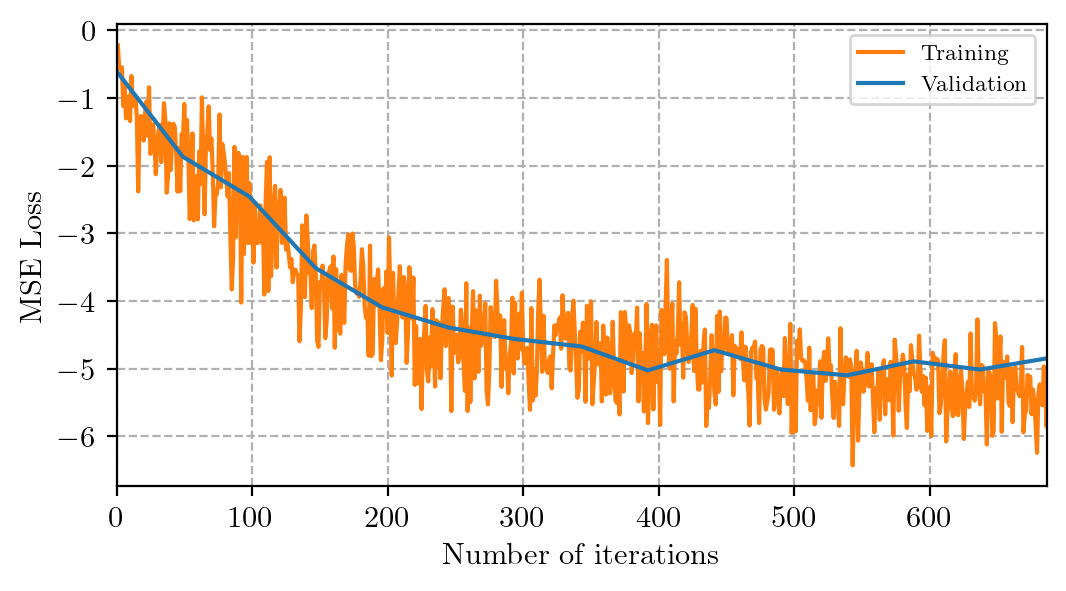

In [48]:
#NN loss plotted to a file:
model.plot_loss(filepath='images/plot_loss.pdf', log_scale=True)

In [14]:
#we take a single event, we remove the last CDM and try to predict it
event = events_test[3]
event_len = len(event)
print(event)
event_beginning = event[0:event_len-1]
print(event_beginning)
event_evolution = model.predict_event(event_beginning, num_samples=100, max_length=14)

ConjunctionEvent(CDMs: 11)
ConjunctionEvent(CDMs: 10)


NameError: name 'ConjunctionEventsDataset' is not defined